In [20]:
import pandas as pd
from transformers import pipeline
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yfinance as yf

In [14]:
def limpar_texto(texto):
    texto = re.sub(r"\d{1,2} de \w+ de \d{4}", "", texto)
    texto = re.sub(r"\d{1,2}h\d{0,2}", "", texto)
    texto = re.sub(r"(?i)(receba as notícias.*?whatsapp.*?)", "", texto)
    texto = re.sub(r"(?i)e-mail inválido.*?(invest)?", "", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"\S+@\S+", "", texto)
    texto = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", texto)
    return texto

In [ ]:
def aplicar_sentimento(caminho_csv, pasta_saida='outputs'):
    print("\n--- FinBERT-PT-BR ---")
    df = pd.read_csv(caminho_csv)
    pipe = pipeline("text-classification", model="lucas-leme/FinBERT-PT-BR")

    
    df['texto_limpo'] = df['texto'].apply(limpar_texto)
    sentimentos = df['texto_limpo'].apply(lambda x: pipe(x[:512])[0])


    df['sentimento'] = sentimentos.apply(lambda s: s['label'])
    df['score_sentimento'] = sentimentos.apply(lambda s: s['score'])

    os.makedirs(pasta_saida, exist_ok=True)
    nome_saida = os.path.basename(caminho_csv).replace('.csv', '_sentimento.csv')
    caminho_saida = os.path.join(pasta_saida, nome_saida)
    df.to_csv(caminho_saida, index=False, encoding='utf-8')
    print("Sentimentos salvos em:", caminho_saida)

    # Sentimento geral
    score_total = 0
    num_total = 0

    for i, row in df.iterrows():
        label = row['sentimento']
        score = row['score_sentimento']
        if label == 'positive':
            score_total += score
            num_total += 1
        elif label == 'negative':
            score_total -= score
            num_total += 1
        elif label == 'neutral':
            # neutros como 0 no calculo
            score_total += 0
            num_total += 1

    if num_total == 0:
        print("Nenhuma notícia classificada.")
        return
    

    # calculo de sentimento
    media = score_total / num_total
    polaridade = (
        "Positive" if media >= 0.15 else
        "Negative" if media <= -0.15 else
        "Neutral"
    )
    print(f"Sentimento geral: {polaridade} (Score médio: {media:.3f})")

In [ ]:
if __name__ == '__main__':
    caminho = "C:\\Users\\femor\\OneDrive\\Área de Trabalho\\Analise de Sentimento\\Part01\\noticias"
    arquivos_csv = [f for f in os.listdir(caminho) if f.endswith('.csv')]

    for nome_arquivo in arquivos_csv:
        caminho_completo = os.path.join(caminho, nome_arquivo)
        print(f"\nProcessando arquivo: {nome_arquivo}")
        aplicar_sentimento(caminho_completo)


Processando arquivo: noticias_2025-05-01.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sentimentos salvos em: outputs\noticias_2025-05-01_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-02.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-02_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-03.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-03_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-04.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-04_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-05.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-05_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-06.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-06_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-07.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-07_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-08.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-08_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-09.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-09_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-10.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-10_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-11.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-11_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-12.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-12_sentimento.csv
Nenhuma notícia classificada.

Processando arquivo: noticias_2025-05-13.csv

--- FinBERT-PT-BR ---


Device set to use cuda:0


Sentimentos salvos em: outputs\noticias_2025-05-13_sentimento.csv
Nenhuma notícia classificada.


In [17]:
pasta_saida = 'outputs'

arquivos_saida = [f for f in os.listdir(pasta_saida) if f.endswith('_sentimento.csv')]

for arquivo in sorted(arquivos_saida):
    caminho_completo = os.path.join(pasta_saida, arquivo)
    print(f"\n--- Visualizando: {arquivo} ---")
    display(pd.read_csv(caminho_completo))


--- Visualizando: noticias_2025-05-01_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/mundo/pacotes-vindos-da-chin...,2025-05-01,Pacotes vindos da China aos EUA sofrerão tarif...,"Pacotes provenientes da China, especialmente a...",Exame,Pacotes provenientes da China especialmente aq...,NEGATIVE,0.831573
1,https://exame.com/invest/mercados/vendas-globa...,2025-05-01,Vendas globais do McDonald’s caem após tarifas...,Percepção negativa sobre os EUA e marcas ameri...,Exame,Percepção negativa sobre os EUA e marcas ameri...,NEGATIVE,0.814640
2,https://exame.com/esg/o-ano-pos-tragedia-desas...,2025-05-01,O ano pós tragédia: desastres climáticos no RS...,Patrocínio: Parceiro institucional: O Rio Gran...,Exame,Patrocínio Parceiro institucional O Rio Grande...,NEGATIVE,0.798423
3,https://exame.com/pop/cantora-nana-caymmi-morr...,2025-05-01,Cantora Nana Caymmi morre aos 84 anos,"Nana Caymmi, uma das grandes intérpretes da mú...",Exame,Nana Caymmi uma das grandes intérpretes da mús...,NEGATIVE,0.779260
4,https://exame.com/invest/mercados/microsoft-au...,2025-05-01,Microsoft aumenta preços do Xbox em meio à gue...,"Microsoft: em comunicado, a Xbox disse que aum...",Exame,Microsoft em comunicado a Xbox disse que aumen...,NEGATIVE,0.798680
...,...,...,...,...,...,...,...,...
76,https://valor.globo.com/eu-e/noticia/2025/05/0...,2025-05-01,Eleição de Míriam Leitão para ABL marca trajet...,01/05/2025 13h24Atualizado01/05/2025 A jornali...,Valor Econômico,01052025 Atualizado01052025 A jornalista e esc...,POSITIVE,0.553575
77,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-01,Dia do Trabalhador é marcado por protestos ant...,Por Valor— Rio 01/05/2025 17h45Atualizado01/05...,Valor Econômico,Por Valor Rio 01052025 Atualizado01052025 ODia...,NEGATIVE,0.824877
78,https://valor.globo.com/empresas/noticia/2025/...,2025-05-01,"Microsoft sobe 9,2% e supera Apple como maior ...",01/05/2025 12h48Atualizado01/05/2025 As ações ...,Valor Econômico,01052025 Atualizado01052025 As ações da Micros...,POSITIVE,0.450748
79,https://valor.globo.com/financas/noticia/2025/...,2025-05-01,Petróleo fecha em forte alta com maior apetite...,Em alta 01/05/2025 16h18Atualizado01/05/2025 O...,Valor Econômico,Em alta 01052025 Atualizado01052025 Os contrat...,POSITIVE,0.528176



--- Visualizando: noticias_2025-05-02_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/mundo/eua-anunciam-desfile-m...,2025-05-02,"EUA anunciam desfile militar em 14 de junho, a...",Agência de notícias Publicado em2 de maio de 2...,Exame,Agência de notícias Publicado em às ACasa Bran...,NEUTRAL,0.473763
1,https://exame.com/pop/morre-a-atriz-mirim-mill...,2025-05-02,"Morre a atriz mirim Millena Brandão, após desc...",Millena Brandão: atriz é conhecida por partici...,Exame,Millena Brandão atriz é conhecida por particip...,NEGATIVE,0.809472
2,https://exame.com/esferabrasil/por-que-o-indic...,2025-05-02,Por que o índice pluviométrico é medido em mil...,São Paulo registra uma média anual de precipit...,Exame,São Paulo registra uma média anual de precipit...,NEGATIVE,0.696046
3,https://exame.com/brasil/com-saida-de-lupi-lul...,2025-05-02,"Com saída de Lupi, Lula faz 11ª troca minister...",Agência de notícias Publicado em2 de maio de 2...,Exame,Agência de notícias Publicado em às Última atu...,NEGATIVE,0.759843
4,https://exame.com/tecnologia/quer-criar-grupos...,2025-05-02,Quer criar grupos no WhatsApp sem adicionar me...,Repórter Publicado em2 de maio de 2025 às19h52...,Exame,Repórter Publicado em às Última atualização em...,NEUTRAL,0.621497
...,...,...,...,...,...,...,...,...
77,https://valor.globo.com/politica/noticia/2025/...,2025-05-02,Análise: Queda de Lupi não blinda o governo,02/05/2025 19h07Atualizado02/05/2025 Aqueda de...,Valor Econômico,02052025 Atualizado02052025 Aqueda de Carlos L...,NEGATIVE,0.794377
78,https://valor.globo.com/financas/criptomoedas/...,2025-05-02,Bitcoin avança para US$ 97 mil com retomada de...,02/05/2025 13h04Atualizado02/05/2025 O bitcoin...,Valor Econômico,02052025 Atualizado02052025 O bitcoin voltou a...,POSITIVE,0.714419
79,https://valor.globo.com/empresas/noticia/2025/...,2025-05-02,Jeff Bezos planeja vender 25 milhões de ações ...,Por Dow Jones— Nova York 02/05/2025 12h00Atual...,Valor Econômico,Por Dow Jones Nova York 02052025 Atualizado020...,NEUTRAL,0.375327
80,https://valor.globo.com/empresas/noticia/2025/...,2025-05-02,"Seis anos depois, construtora Odebrecht volta ...",Por Folhapress— São Paulo 02/05/2025 19h32Atua...,Valor Econômico,Por Folhapress São Paulo 02052025 Atualizado02...,NEUTRAL,0.418820



--- Visualizando: noticias_2025-05-03_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/pop/estamos-fazendo-historia...,2025-05-03,"Estamos fazendo história, diz Lady Gaga em sho...",Lady Gaga: cantora sorteou fã brasileiro para ...,Exame,Lady Gaga cantora sorteou fã brasileiro para l...,NEUTRAL,0.474790
1,https://exame.com/invest/mercados/elon-musk-te...,2025-05-03,Elon Musk terá sua própria cidade no Texas; en...,"Estátua de Elon Musk em Brownsville, no caminh...",Exame,Estátua de Elon Musk em Brownsville no caminho...,NEUTRAL,0.525561
2,https://exame.com/pop/multidao-toma-o-metro-ru...,2025-05-03,Multidão toma o metrô rumo a Copacabana para s...,A cantora Lady Gaga se apresenta antes da ceri...,Exame,A cantora Lady Gaga se apresenta antes da ceri...,NEUTRAL,0.510962
3,https://exame.com/mundo/presidente-do-senado-r...,2025-05-03,Presidente do Senado rompe com Morales e lança...,Presidente do Senado rompe com Morales e lança...,Exame,Presidente do Senado rompe com Morales e lança...,NEGATIVE,0.622109
4,https://exame.com/invest/minhas-financas/mega-...,2025-05-03,Mega-Sena concurso 2.858: veja os números sort...,Mega-Sena concurso 2.858: veja os números sort...,Exame,MegaSena concurso 2858 veja os números sortead...,NEUTRAL,0.526556
...,...,...,...,...,...,...,...,...
60,https://valor.globo.com/politica/noticia/2025/...,2025-05-03,"Nomeado durante crise no INSS, novo ministro d...",Por Agência Globo— São Paulo 03/05/2025 20h30A...,Valor Econômico,Por Agência Globo São Paulo 03052025 Atualizad...,NEGATIVE,0.579776
61,https://valor.globo.com/politica/noticia/2025/...,2025-05-03,Oposição articula instalação de CPI mista do INSS,03/05/2025 17h26Atualizado03/05/2025 O requeri...,Valor Econômico,03052025 Atualizado03052025 O requerimento de ...,NEGATIVE,0.676260
62,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-03,Trump publica foto vestido como papa gerada po...,Por Agência Globo com agências internacionais—...,Valor Econômico,Por Agência Globo com agências internacionais ...,NEUTRAL,0.563193
63,https://valor.globo.com/carreira/noticia/2025/...,2025-05-03,Índices de engajamento de funcionários caem em...,03/05/2025 07h15Atualizado03/05/2025 As taxas ...,Valor Econômico,03052025 Atualizado03052025 As taxas de engaja...,NEGATIVE,0.839845



--- Visualizando: noticias_2025-05-04_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/brasil/escolhida-por-lula-pa...,2025-05-04,Escolhida por Lula para Ministério das Mulhere...,"Márcia Lopes, assistente social: “Ele me convi...",Exame,Márcia Lopes assistente social Ele me convidou...,NEUTRAL,0.666979
1,https://exame.com/ciencia/quais-tecnologias-de...,2025-05-04,Quais tecnologias de ‘Star Wars’ já são realid...,Star Wars: franquia de ficção científica foi c...,Exame,Star Wars franquia de ficção científica foi cr...,NEUTRAL,0.578133
2,https://exame.com/mundo/conclave-eleicao-do-no...,2025-05-04,Conclave: eleição do novo Papa será nesta sema...,Cardeais irão se reunir na Capela Sistina para...,Exame,Cardeais irão se reunir na Capela Sistina para...,NEUTRAL,0.659899
3,https://exame.com/brasil/plano-de-atentado-em-...,2025-05-04,Plano de atentado em show de Lady Gaga: políci...,Outros mandados foram cumpridos nas cidades de...,Exame,Outros mandados foram cumpridos nas cidades de...,NEGATIVE,0.752919
4,https://exame.com/mundo/ultradireita-lidera-pr...,2025-05-04,Ultradireita lidera primeiro turno das preside...,"George Simion, líder do partido AUR, se inspir...",Exame,George Simion líder do partido AUR se inspira ...,NEGATIVE,0.818318
5,https://exame.com/brasil/escala-6x1-reducao-da...,2025-05-04,Escala 6x1: redução da jornada de trabalho ser...,Gleisi Hoffmann: “O debate sobre o fim da esca...,Exame,Gleisi Hoffmann O debate sobre o fim da escala...,NEGATIVE,0.533407
6,https://exame.com/brasil/haddad-se-reune-com-s...,2025-05-04,Haddad se reúne com secretário do Tesouro de T...,Fernando Haddad e o Secretário de Tesouro dos ...,Exame,Fernando Haddad e o Secretário de Tesouro dos ...,NEUTRAL,0.674003
7,https://exame.com/mundo/trump-sinaliza-disposi...,2025-05-04,Trump sinaliza disposição para reduzir tarifas...,Porto na China: guerra comercial com EUA afeta...,Exame,Porto na China guerra comercial com EUA afeta ...,NEGATIVE,0.813211
8,https://exame.com/mundo/zelensky-diz-que-nao-a...,2025-05-04,Zelensky diz que não acredita que a Rússia vai...,"Volodimir Zelensky, presidente da Ucrânia: “Es...",Exame,Volodimir Zelensky presidente da Ucrânia Esse ...,NEGATIVE,0.770890
9,https://exame.com/esg/heineken-investe-mais-de...,2025-05-04,Heineken investe mais de R$ 130 milhões para e...,Patrocínio: Parceiro institucional: A companhi...,Exame,Patrocínio Parceiro institucional A companhia ...,POSITIVE,0.445003



--- Visualizando: noticias_2025-05-05_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/pop/no-palco-e-nas-telonas-4...,2025-05-05,No palco e nas telonas: 4 filmes com Lady Gaga...,"Lady Gaga: nos palcos, nos fones e nas telonas...",Exame,Lady Gaga nos palcos nos fones e nas telonas N...,NEUTRAL,0.522128
1,https://exame.com/pop/show-de-lady-gaga-no-rio...,2025-05-05,Show de Lady Gaga no Rio: playback ou performa...,Lady Gaga: ao vivo ou playback? (PABLO PORCIUN...,Exame,Lady Gaga ao vivo ou playback PABLO PORCIUNCUL...,NEGATIVE,0.536463
2,https://exame.com/pop/met-gala-2025-os-melhore...,2025-05-05,Met Gala 2025: os melhores looks da 'noite mai...,Doechii: cantora é um dos destaques desta noit...,Exame,Doechii cantora é um dos destaques desta noite...,NEUTRAL,0.470330
3,https://exame.com/exame-in/tanure-amarga-derro...,2025-05-05,"Tanure amarga derrota e GPA, agora, é ‘página ...","Das três cadeiras desejadas, empresário acabou...",Exame,Das três cadeiras desejadas empresário acabou ...,NEGATIVE,0.775975
4,https://exame.com/brasil/infraestrutura/camara...,2025-05-05,Câmara pode votar nova lei de concessões e PPP...,Plenário da Câmara dos Deputados: novo marco l...,Exame,Plenário da Câmara dos Deputados novo marco le...,NEUTRAL,0.667970
...,...,...,...,...,...,...,...,...
71,https://valor.globo.com/empresas/noticia/2025/...,2025-05-05,Saiba quais foram os maiores shows em Copacabana,05/05/2025 15h44Atualizado05/05/2025 As areias...,Valor Econômico,05052025 Atualizado05052025 As areias da praia...,NEUTRAL,0.419739
72,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-05,Confiança do consumidor australiano se recuper...,05/05/2025 22h53Atualizado05/05/2025 A confian...,Valor Econômico,05052025 Atualizado05052025 A confiança do con...,NEGATIVE,0.806402
73,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-05,Cardeais que participarão do conclave ainda nã...,Por Reuters— Cidade do Vaticano 05/05/2025 16h...,Valor Econômico,Por Reuters Cidade do Vaticano 05052025 Atuali...,NEGATIVE,0.792650
74,https://valor.globo.com/empresas/noticia/2025/...,2025-05-05,Prejuízo da Mattel cresce quase 50% no 1º trim...,05/05/2025 17h56Atualizado05/05/2025 Oprejuízo...,Valor Econômico,05052025 Atualizado05052025 Oprejuízodafabrica...,POSITIVE,0.623948



--- Visualizando: noticias_2025-05-06_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/economia/em-liminar-justica-...,2025-05-06,"Em liminar, Justiça do DF proíbe BRB de assina...",Publicado em6 de maio de 2025 às22h23. O juiz ...,Exame,Publicado em às O juiz de direito substitutoCa...,NEGATIVE,0.685140
1,https://exame.com/mundo/eua-e-china-se-reunira...,2025-05-06,EUA e China se reunirão para iniciar negociaçõ...,EUA vs. China: negociações tarifárias começam ...,Exame,EUA vs China negociações tarifárias começam ne...,NEUTRAL,0.623107
2,https://exame.com/mundo/10-curiosidades-sobre-...,2025-05-06,10 curiosidades sobre o Conclave,"O conclave é realizado na Capela Sistina, famo...",Exame,O conclave é realizado na Capela Sistina famos...,NEUTRAL,0.664930
3,https://exame.com/brasil/em-votacao-apertada-c...,2025-05-06,"Em votação apertada, Câmara aprova urgência de...",A matéria é polêmica na Casa e coloca deputado...,Exame,A matéria é polêmica na Casa e coloca deputado...,NEUTRAL,0.569407
4,https://exame.com/invest/minhas-financas/mega-...,2025-05-06,Mega-Sena concurso 2.859: veja os números sort...,"Mega-Sena sorteia prêmio de R$ 17,5 milhões ne...",Exame,MegaSena sorteia prêmio de R 175 milhões nesta...,NEUTRAL,0.556024
...,...,...,...,...,...,...,...,...
75,https://valor.globo.com/financas/noticia/2025/...,2025-05-06,Antecipação do benefício do INSS será suspensa...,Em alta 06/05/2025 21h07Atualizado06/05/2025 A...,Valor Econômico,Em alta 06052025 Atualizado06052025 A decisão ...,NEGATIVE,0.808996
76,https://valor.globo.com/politica/noticia/2025/...,2025-05-06,Câmara aprova urgência para votar projeto que ...,06/05/2025 20h13Atualizado06/05/2025 ACâmara d...,Valor Econômico,06052025 Atualizado06052025 ACâmara dos Deputa...,NEUTRAL,0.537982
77,https://valor.globo.com/politica/noticia/2025/...,2025-05-06,Conselho de Ética suspende Gilvan da Federal p...,06/05/2025 17h09Atualizado06/05/2025 OConselho...,Valor Econômico,06052025 Atualizado06052025 OConselho de Ética...,NEGATIVE,0.823864
78,https://valor.globo.com/brasil/noticia/2025/05...,2025-05-06,Silveira: Envio de MP do setor elétrico ao Con...,06/05/2025 21h27Atualizado06/05/2025 O ministr...,Valor Econômico,06052025 Atualizado06052025 O ministro de Mina...,NEUTRAL,0.592972



--- Visualizando: noticias_2025-05-07_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/invest/mercados/bradesco-sup...,2025-05-07,"Bradesco supera consenso e lucra R$5,9 bilhões...","Bradesco lucra R$5,9 bilhões no primeiro trime...",Exame,Bradesco lucra R59 bilhões no primeiro trimest...,POSITIVE,0.706303
1,https://exame.com/agro/resultado-da-brasilagro...,2025-05-07,Resultado da BrasilAgro melhora no 3º trimestr...,Plantação de soja (Gary Conner/Getty Images) R...,Exame,Plantação de soja Gary ConnerGetty Images Repó...,NEGATIVE,0.711237
2,https://exame.com/invest/mercados/mercado-livr...,2025-05-07,Mercado Livre traz CEO da Dengo para comandar ...,Landin: executivo comandava Dengo desde 2022 (...,Exame,Landin executivo comandava Dengo desde 2022 Ed...,NEUTRAL,0.537941
3,https://exame.com/pop/gta-6-veja-novo-teaser-c...,2025-05-07,GTA 6: veja novo teaser com protagonistas e ce...,GTA 6: estreia do jogo é adiada Redação Exame ...,Exame,GTA 6 estreia do jogo é adiada Redação Exame P...,NEUTRAL,0.490380
4,https://exame.com/esporte/fifa-anuncia-as-oito...,2025-05-07,Fifa anuncia as oito sedes da Copa do Mundo Fe...,Copa do Mundo Feminina: Brasil sediará evento ...,Exame,Copa do Mundo Feminina Brasil sediará evento e...,NEUTRAL,0.593475
...,...,...,...,...,...,...,...,...
70,https://valor.globo.com/politica/noticia/2025/...,2025-05-07,Alexandre de Moraes marca datas para ouvir tes...,07/05/2025 15h19Atualizado07/05/2025 O ministr...,Valor Econômico,07052025 Atualizado07052025 O ministroAlexandr...,NEGATIVE,0.635114
71,https://valor.globo.com/brasil/noticia/2025/05...,2025-05-07,"Índice de commodities do BC recua 0,83% em abril",07/05/2025 15h21Atualizado07/05/2025 O preço d...,Valor Econômico,07052025 Atualizado07052025 O preço das matéri...,NEGATIVE,0.802070
72,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-07,Saiba quando será a próxima votação para escol...,07/05/2025 16h01Atualizado07/05/2025 Após o fi...,Valor Econômico,07052025 Atualizado07052025 Após o fim da prim...,NEUTRAL,0.566693
73,https://valor.globo.com/financas/noticia/2025/...,2025-05-07,Fluxo cambial registra entrada líquida de US$ ...,Em alta 07/05/2025 15h08Atualizado07/05/2025 O...,Valor Econômico,Em alta 07052025 Atualizado07052025 O Banco Ce...,POSITIVE,0.509929



--- Visualizando: noticias_2025-05-08_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/invest/minhas-financas/mega-...,2025-05-08,Mega-Sena: resultado do concurso 2.860; prêmio...,Repórter Publicado em8 de maio de 2025 às20h07...,Exame,Repórter Publicado em às ACaixarealizou nesta ...,NEUTRAL,0.609020
1,https://exame.com/invest/mercados/itau-itub4-t...,2025-05-08,"Itaú (ITUB4) tem lucro de R$ 11,12 bilhões no ...",Itaú (Itaú/Wikimedia Commons) Repórter de merc...,Exame,Itaú ItaúWikimedia Commons Repórter de mercado...,POSITIVE,0.775335
2,https://exame.com/mundo/papa-leao-xiv-celebra-...,2025-05-08,Papa Leão XIV celebra sua 1º missa no Vaticano...,"Papa Leão XIV: ""Deus nos ama, ama a todos você...",Exame,Papa Leão XIV Deus nos ama ama a todos vocês e...,NEUTRAL,0.618260
3,https://exame.com/economia/uniao-vai-garantir-...,2025-05-08,União vai garantir ressarcimento a vítimas de ...,Agência de notícias Publicado em8 de maio de 2...,Exame,Agência de notícias Publicado em às Última atu...,NEGATIVE,0.764746
4,https://exame.com/brasil/stf-homologa-acordo-q...,2025-05-08,STF homologa acordo que amplia uso de câmeras ...,PM de São Paulo com câmera corporal (Governo d...,Exame,PM de São Paulo com câmera corporal Governo do...,NEUTRAL,0.538425
...,...,...,...,...,...,...,...,...
64,https://valor.globo.com/financas/noticia/2025/...,2025-05-08,Ibovespa fecha em alta de mais de 2% com ciclo...,Em alta 08/05/2025 17h32Atualizado08/05/2025 E...,Valor Econômico,Em alta 08052025 Atualizado08052025 Em um dia ...,NEGATIVE,0.576357
65,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-08,Robert Francis Prevost é eleito papa e se cham...,08/05/2025 15h05Atualizado08/05/2025 Primeiro ...,Valor Econômico,08052025 Atualizado08052025 Primeiro papa nort...,NEGATIVE,0.737276
66,https://valor.globo.com/empresas/noticia/2025/...,2025-05-08,"Lucro da Totvs sobe 53,7% no trimestre, para R...",08/05/2025 19h43Atualizado08/05/2025 ATotvsenc...,Valor Econômico,08052025 Atualizado08052025 ATotvsencerrou o p...,POSITIVE,0.795632
67,https://valor.globo.com/financas/noticia/2025/...,2025-05-08,"Com ciclo de altas da Selic próximo do fim, ba...",Em alta 08/05/2025 15h18Atualizado08/05/2025 E...,Valor Econômico,Em alta 08052025 Atualizado08052025 Em meio às...,NEGATIVE,0.709011



--- Visualizando: noticias_2025-05-09_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/brasil/stf-tem-maioria-para-...,2025-05-09,STF tem maioria para condenar deputada Carla Z...,Ministros do STF também votaram pela perda do ...,Exame,Ministros do STF também votaram pela perda do ...,NEGATIVE,0.820551
1,https://exame.com/brasil/eduardo-leite-se-fili...,2025-05-09,Eduardo Leite se filia ao PSD e diz que não pr...,Leite pontuou que não pretende ser candidato “...,Exame,Leite pontuou que não pretende ser candidato a...,NEUTRAL,0.682905
2,https://exame.com/mundo/argentinos-nao-precisa...,2025-05-09,Argentinos não precisam mais escalar o Obelisc...,Obelisco de Buenos Aires: elevador turístico p...,Exame,Obelisco de Buenos Aires elevador turístico pr...,POSITIVE,0.489625
3,https://exame.com/marketing/vale-tudo-maria-de...,2025-05-09,Vale Tudo: Maria de Fátima fez 1ª presença VIP...,Maria de Fátima (Bella Campos) na área exclusi...,Exame,Maria de Fátima Bella Campos na área exclusiva...,POSITIVE,0.478335
4,https://exame.com/invest/minhas-financas/consi...,2025-05-09,Consignado CLT: Banco do Brasil lidera ranking...,"Diante da dificuldade crônica com os bancos, p...",Exame,Diante da dificuldade crônica com os bancos pa...,NEUTRAL,0.341217
...,...,...,...,...,...,...,...,...
78,https://valor.globo.com/empresas/noticia/2025/...,2025-05-09,Descoberta em Aram é a quarta anunciada pela P...,09/05/2025 16h19Atualizado09/05/2025 A descobe...,Valor Econômico,09052025 Atualizado09052025 A descoberta de pe...,POSITIVE,0.534239
79,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-09,Lista de países 'prioritários' para negociaçõe...,09/05/2025 17h04Atualizado09/05/2025 A lista d...,Valor Econômico,09052025 Atualizado09052025 A lista de países ...,NEUTRAL,0.608478
80,https://valor.globo.com/financas/noticia/2025/...,2025-05-09,Movimento global para rejeitar dólar ganha for...,Em alta Por Bloomberg 09/05/2025 16h55Atualiza...,Valor Econômico,Em alta Por Bloomberg 09052025 Atualizado09052...,NEGATIVE,0.514475
81,https://valor.globo.com/empresas/noticia/2025/...,2025-05-09,Rumo reforça projeções para o ano mesmo com vo...,"09/05/2025 15h20Atualizado09/05/2025 ARumo, em...",Valor Econômico,09052025 Atualizado09052025 ARumo empresa de l...,NEGATIVE,0.478775



--- Visualizando: noticias_2025-05-10_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/mundo/trump-pede-20-mil-novo...,2025-05-10,Trump pede 20 mil novos policiais para reforço...,"Donald Trump, presidente dos EUA (Jim Watson/A...",Exame,Donald Trump presidente dos EUA Jim WatsonAFP ...,NEGATIVE,0.571880
1,https://exame.com/negocios/balneario-camboriu-...,2025-05-10,Balneário Camboriú lança o prédio residencial ...,"Senna Tower, em Balneário Camboriú: maquete te...",Exame,Senna Tower em Balneário Camboriú maquete tem ...,NEUTRAL,0.426774
2,https://exame.com/mundo/china-diz-que-primeira...,2025-05-10,China diz que primeiras discussões comerciais ...,"Mesa de discussões com He Lifeng, vicê-premiê ...",Exame,Mesa de discussões com He Lifeng vicêpremiê da...,NEUTRAL,0.618854
3,https://exame.com/invest/onde-investir/ouro-a-...,2025-05-10,"Ouro a US$ 6 mil? Para este banco, metal pode ...",Ouro: JP Morgan prevê metal a US$ 4 mil já no ...,Exame,Ouro JP Morgan prevê metal a US 4 mil já no se...,NEUTRAL,0.420921
4,https://exame.com/brasil/mp-pede-cassacao-de-p...,2025-05-10,MP pede cassação de prefeito de Curitiba e vic...,"Eduardo Pimentel (PSD), prefeito de Curitiba (...",Exame,Eduardo Pimentel PSD prefeito de Curitiba Band...,NEGATIVE,0.845625
5,https://exame.com/mundo/museu-bale-e-catedral-...,2025-05-10,"Museu, balé e catedral: saiba qual foi a progr...",Lula chega acompanhado de Janja para a Assembl...,Exame,Lula chega acompanhado de Janja para a Assembl...,NEUTRAL,0.549102
6,https://exame.com/economia/justica-proibe-fina...,2025-05-10,Justiça proíbe financeiras de bloquearem celul...,Agência de notícias Publicado em10 de maio de ...,Exame,Agência de notícias Publicado em às Última atu...,NEGATIVE,0.820098
7,https://exame.com/brasil/inss-governo-ira-noti...,2025-05-10,INSS: governo irá notificar 9 milhões de apose...,Agência do INSS (Agência Brasil) Agência de no...,Exame,Agência do INSS Agência Brasil Agência de notí...,NEGATIVE,0.812936
8,https://exame.com/brasil/tempo-vira-em-sp-e-ta...,2025-05-10,Tempo vira em SP e tarde é de chuva; Defesa Ci...,Frente fria: sistema avança pelo litoral pauli...,Exame,Frente fria sistema avança pelo litoral paulis...,NEGATIVE,0.811879
9,https://exame.com/pop/taylor-swift-e-intimada-...,2025-05-10,Taylor Swift é intimada como testemunha em dis...,"Equipe de Taylor diz que ""intimação foi “fabri...",Exame,Equipe de Taylor diz que intimação foi fabrica...,NEGATIVE,0.710635



--- Visualizando: noticias_2025-05-11_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/mundo/trump-promete-ordem-ex...,2025-05-11,Trump promete ordem executiva para reduzir pre...,Redação Exame Publicado em11 de maio de 2025 à...,Exame,Redação Exame Publicado em às Última atualizaç...,NEGATIVE,0.727231
1,https://exame.com/marketing/gigante-chinesa-de...,2025-05-11,"Gigante chinesa de delivery, Meituan chega ao ...",(Barcroft Media / Colaborador/Getty Images) Ed...,Exame,Barcroft Media ColaboradorGetty Images Editor...,POSITIVE,0.793856
2,https://exame.com/mundo/eua-e-china-anunciam-i...,2025-05-11,EUA e China anunciam importantes avanços em ne...,Agência de notícias Publicado em11 de maio de ...,Exame,Agência de notícias Publicado em às Os Estados...,NEGATIVE,0.731468
3,https://exame.com/marketing/com-recorde-de-pub...,2025-05-11,"Com recorde de público, Web Summit Rio segue a...",Eduardo Paes durante a abertura do Web Summit ...,Exame,Eduardo Paes durante a abertura do Web Summit ...,POSITIVE,0.709366
4,https://exame.com/mundo/israel-diz-que-guerra-...,2025-05-11,"Israel diz que guerra em Gaza vai continuar, a...",(Ohad Zwigenberg/AFP) Agência de notícias Publ...,Exame,Ohad ZwigenbergAFP Agência de notícias Publica...,NEGATIVE,0.774445
5,https://exame.com/invest/mercados/openai-e-mic...,2025-05-11,OpenAI e Microsoft renegociam parceria para vi...,"Sam Altman, CEO da OpenAI, e o vice-presidente...",Exame,Sam Altman CEO da OpenAI e o vicepresidente de...,POSITIVE,0.670256
6,https://exame.com/marketing/mcdonalds-traz-gri...,2025-05-11,McDonald’s traz Grimace Shake de volta em nova...,McDonald’s traz Grimace de volta e escala Rays...,Exame,McDonalds traz Grimace de volta e escala Rayss...,POSITIVE,0.637909
7,https://exame.com/mundo/hamas-anuncia-que-vai-...,2025-05-11,Hamas anuncia que vai libertar refém israelens...,(AFP Photo) Redação Exame Publicado em11 de ma...,Exame,AFP Photo Redação Exame Publicado em às Última...,NEGATIVE,0.696765
8,https://exame.com/mundo/vice-premie-chines-sau...,2025-05-11,Vice-premiê chinês saúda 'avanços importantes'...,Agência de notícias Publicado em11 de maio de ...,Exame,Agência de notícias Publicado em às O viceprim...,NEUTRAL,0.475035
9,https://exame.com/mundo/trump-cogita-aceitar-b...,2025-05-11,Trump cogita aceitar Boeing de luxo como prese...,Agência de notícias Publicado em11 de maio de ...,Exame,Agência de notícias Publicado em às Ogoverno T...,NEUTRAL,0.606884



--- Visualizando: noticias_2025-05-12_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/brasil/precisamos-enfrentar-...,2025-05-12,Precisamos enfrentar problemas reais e não ape...,Leite: governador diz que tem apetite para lid...,Exame,Leite governador diz que tem apetite para lide...,NEUTRAL,0.505388
1,https://exame.com/invest/mercados/lucro-liquid...,2025-05-12,Lucro líquido da Petrobras chega a R$ 35 bi e ...,Petrobras: empresa aumentou investimentos na c...,Exame,Petrobras empresa aumentou investimentos na co...,POSITIVE,0.703438
2,https://exame.com/ciencia/nova-york-esta-afund...,2025-05-12,"Nova York está afundando, mostram imagens de s...",Dados de satélites mostram que cidades como No...,Exame,Dados de satélites mostram que cidades como No...,NEGATIVE,0.836603
3,https://exame.com/ciencia/tchau-cansaco-5-estr...,2025-05-12,"Tchau, cansaço: 5 estratégias comprovadas pela...",Saiba como combater a fadiga mental com estrat...,Exame,Saiba como combater a fadiga mental com estrat...,NEUTRAL,0.498432
4,https://exame.com/invest/mercados/petrobras-pe...,2025-05-12,"Petrobras (PETR3/ PETR4) vai pagar R$ 11,72 bi...",Petrobras: dividendos à vista (Petrobras/Divul...,Exame,Petrobras dividendos à vista PetrobrasDivulgaç...,NEUTRAL,0.620739
...,...,...,...,...,...,...,...,...
74,https://valor.globo.com/empresas/noticia/2025/...,2025-05-12,"Atrasada após denúncias, fábrica da BYD no Bra...",Por Reuters— São Paulo 12/05/2025 16h39Atualiz...,Valor Econômico,Por Reuters São Paulo 12052025 Atualizado12052...,NEGATIVE,0.535523
75,https://valor.globo.com/empresas/marketing/not...,2025-05-12,WMcCann contrata ex-diretor de estratégia da Fbiz,12/05/2025 11h58Atualizado12/05/2025 AWMcCanna...,Valor Econômico,12052025 Atualizado12052025 AWMcCannanunciou n...,NEUTRAL,0.601519
76,https://valor.globo.com/empresas/noticia/2025/...,2025-05-12,Queda nas vendas leva indústria de caminhões a...,12/05/2025 11h25Atualizado12/05/2025 Depois de...,Valor Econômico,12052025 Atualizado12052025 Depois de meses co...,NEGATIVE,0.669020
77,https://valor.globo.com/politica/noticia/2025/...,2025-05-12,Alexandre de Moraes nega pedido da defesa de Z...,12/05/2025 19h27Atualizado12/05/2025 O ministr...,Valor Econômico,12052025 Atualizado12052025 O ministroAlexandr...,NEGATIVE,0.842932



--- Visualizando: noticias_2025-05-13_sentimento.csv ---


,url,data,titulo,texto,fonte,texto_limpo,sentimento,score_sentimento
0,https://exame.com/brasil/governo-lula-paralisa...,2025-05-13,Governo Lula paralisa cessão da área da favela...,Agência de notícias Publicado em13 de maio de ...,Exame,Agência de notícias Publicado em às Última atu...,NEGATIVE,0.826795
1,https://exame.com/pop/pepe-mujica-veja-livros-...,2025-05-13,'Pepe' Mujica: conheça livros sobre o ex-presi...,Encontro entre Mujica e Chomsky foi frutífero ...,Exame,Encontro entre Mujica e Chomsky foi frutífero ...,NEUTRAL,0.570876
2,https://exame.com/invest/minhas-financas/proco...,2025-05-13,Procon-SP notifica Nintendo por cláusulas abus...,"NEW YORK, NY - MARCH 3: A person dressed as th...",Exame,NEW YORK NY MARCH 3 A person dressed as the N...,NEGATIVE,0.447887
3,https://exame.com/mundo/houthis-pedem-que-trum...,2025-05-13,Houthis pedem que Trump pare de apoiar Israel ...,Agência de Notícias Publicado em13 de maio de ...,Exame,Agência de Notícias Publicado em às Os insurge...,NEGATIVE,0.805492
4,https://exame.com/brasil/prefeito-de-sorocaba-...,2025-05-13,Prefeito de Sorocaba (SP) vira réu por suspeit...,"Prefeito 'tiktoker de Sorocaba', Rodrigo Manga...",Exame,Prefeito tiktoker de Sorocaba Rodrigo Manga Di...,NEGATIVE,0.836482
...,...,...,...,...,...,...,...,...
69,https://valor.globo.com/financas/noticia/2025/...,2025-05-13,"Dólar tem queda forte e vai a R$ 5,60, no meno...",Em alta 13/05/2025 17h08Atualizado13/05/2025 O...,Valor Econômico,Em alta 13052025 Atualizado13052025 Odólar à v...,NEGATIVE,0.740119
70,https://valor.globo.com/mundo/noticia/2025/05/...,2025-05-13,EUA sancionam empresas acusadas de enviar petr...,13/05/2025 17h19Atualizado13/05/2025 ODepartam...,Valor Econômico,13052025 Atualizado13052025 ODepartamento do T...,NEGATIVE,0.845180
71,https://valor.globo.com/financas/noticia/2025/...,2025-05-13,Ibovespa dispara e bate recorde com perspectiv...,Em alta 13/05/2025 17h32Atualizado13/05/2025 A...,Valor Econômico,Em alta 13052025 Atualizado13052025 A leitura ...,POSITIVE,0.689693
72,https://valor.globo.com/empresas/noticia/2025/...,2025-05-13,Redução de custos não vai impactar planos para...,13/05/2025 17h19Atualizado13/05/2025 Apresiden...,Valor Econômico,13052025 Atualizado13052025 Apresidente daPetr...,NEUTRAL,0.403041


C:\Users\femor\AppData\Local\Temp\ipykernel_9852\4247763094.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentimento', order=df['sentimento'].value_counts().index, palette='pastel')


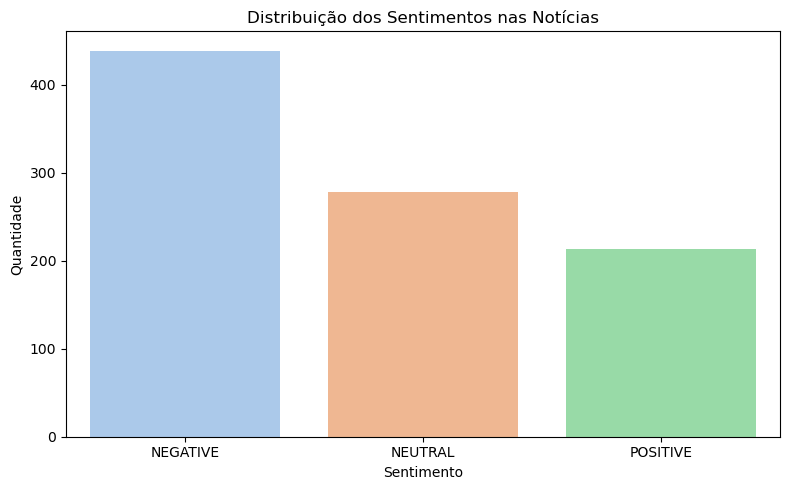

C:\Users\femor\AppData\Local\Temp\ipykernel_9852\4247763094.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentimento', y='score_sentimento', palette='muted')


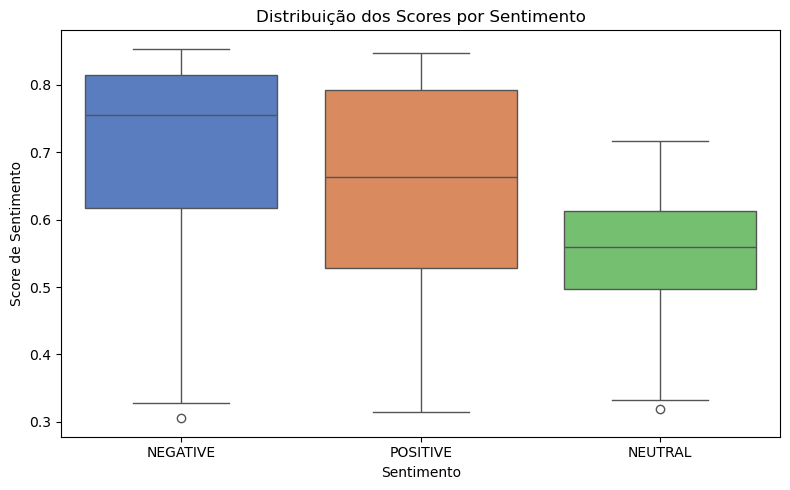

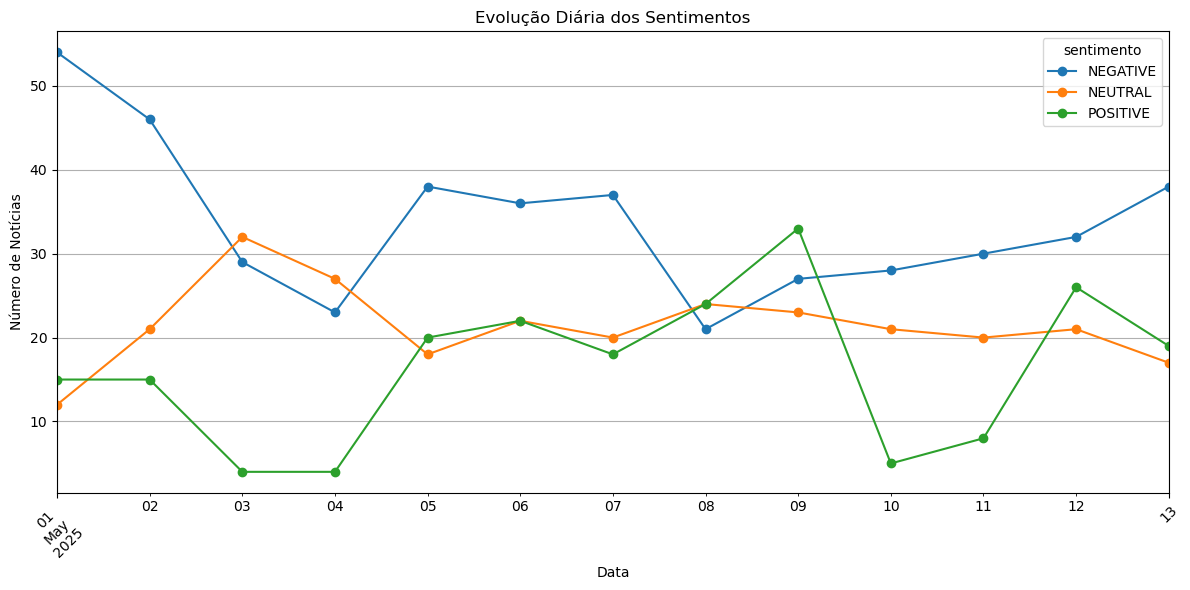

In [ ]:
pasta_outputs = r"C:\Users\femor\OneDrive\Área de Trabalho\Analise de Sentimento\outputs"

# Lista de todos os arquivos na pasta
arquivos = os.listdir(pasta_outputs)

# Filtrar apenas os arquivos CSV
arquivos_csv = [arquivo for arquivo in arquivos if arquivo.endswith(".csv")]

# Carregar e concatenar os arquivos CSV
lista_dfs = []
for nome_arquivo in arquivos_csv:
    caminho_completo = os.path.join(pasta_outputs, nome_arquivo)
    try:
        df_temp = pd.read_csv(caminho_completo)
        lista_dfs.append(df_temp)
    except Exception as e:
        print(f"Erro ao carregar {nome_arquivo}: {e}")

# Concatenar todos os DataFrames
df = pd.concat(lista_dfs, ignore_index=True)

# Converter a coluna 'data' para datetime
df['data'] = pd.to_datetime(df['data'], errors='coerce')
df = df.dropna(subset=['data'])



# 1. Contagem de sentimentos
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentimento', order=df['sentimento'].value_counts().index, palette='pastel')
plt.title("Distribuição dos Sentimentos nas Notícias")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

# 2. Score médio por sentimento
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sentimento', y='score_sentimento', palette='muted')
plt.title("Distribuição dos Scores por Sentimento")
plt.xlabel("Sentimento")
plt.ylabel("Score de Sentimento")
plt.tight_layout()
plt.show()

# 3. Evolução diária dos sentimentos
df_grouped = df.groupby(['data', 'sentimento']).size().unstack().fillna(0)
df_grouped.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Evolução Diária dos Sentimentos")
plt.xlabel("Data")
plt.ylabel("Número de Notícias")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df['data'] = pd.to_datetime(df['data'], errors='coerce')

# Junta sentimento médio por data
df_sent_diario = df.groupby('data')['score_sentimento'].mean().reset_index()
df_sent_diario.rename(columns={'score_sentimento': 'sentimento_medio'}, inplace=True)

# Define ticker e datas
ticker = "PETR4.SA"
inicio = df_sent_diario['data'].min().strftime('%Y-%m-%d')
fim = df_sent_diario['data'].max().strftime('%Y-%m-%d')

# Baixa dados da ação
dados_acao = yf.download(ticker, start=inicio, end=fim)

#remove multiindex das colunas 
dados_acao.columns.name = None
dados_acao.columns = [col if isinstance(col, str) else col[0] for col in dados_acao.columns]

dados_acao.reset_index(inplace=True)

# Usa 'Adj Close' se existir, senão usa 'Close'
if 'Adj Close' in dados_acao.columns:
    dados_acao = dados_acao[['Date', 'Adj Close']]
    dados_acao.rename(columns={'Date': 'data', 'Adj Close': 'preco_ajustado'}, inplace=True)
else:
    dados_acao = dados_acao[['Date', 'Close']]
    dados_acao.rename(columns={'Date': 'data', 'Close': 'preco_ajustado'}, inplace=True)

# Converter 'data' para datetime 
dados_acao['data'] = pd.to_datetime(dados_acao['data'], errors='coerce')

# Calcular retorno percentual
dados_acao['retorno_pct'] = dados_acao['preco_ajustado'].pct_change()
dados_acao.dropna(inplace=True)

# Merge com sentimentos
df_merged = pd.merge(df_sent_diario, dados_acao, on='data', how='inner')

# Ajuste do sentimento
df_merged['sentimento_ajustado'] = df_merged['sentimento_medio'] - df_merged['sentimento_medio'].mean()

# Resultado final
display(df_merged.head())

[*********************100%***********************]  1 of 1 completed


,data,sentimento_medio,preco_ajustado,retorno_pct,sentimento_ajustado
0,2025-05-05,0.652114,29.660000,-0.037326,0.010794
1,2025-05-06,0.679920,30.150000,0.016521,0.038600
2,2025-05-07,0.629638,30.290001,0.004643,-0.011681
3,2025-05-08,0.656410,30.709999,0.013866,0.015090
4,2025-05-09,0.605563,30.910000,0.006513,-0.035756


In [94]:
print(dados_acao.columns)

MultiIndex([(          'data',         ''),
            ('preco_ajustado', 'PETR4.SA')],
           names=['Price', 'Ticker'])


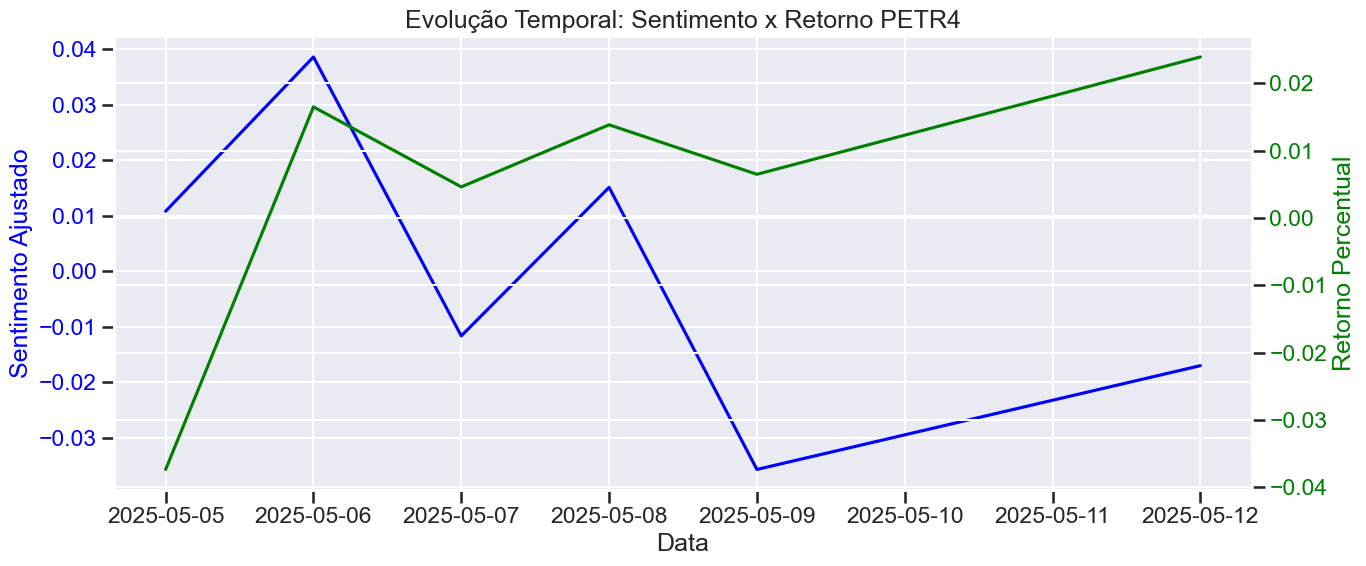

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")


fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_title('Evolução Temporal: Sentimento x Retorno PETR4')
ax1.set_xlabel('Data')
ax1.set_ylabel('Sentimento Ajustado', color='blue')
ax1.plot(df_merged['data'], df_merged['sentimento_ajustado'], color='blue', label='Sentimento Ajustado')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.set_ylabel('Retorno Percentual', color='green')
ax2.plot(df_merged['data'], df_merged['retorno_pct'], color='green', label='Retorno % PETR4')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
plt.show()
